In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd '/content/drive/MyDrive/cs/cs133/project_folder'

/content/drive/MyDrive/cs/cs133/project_folder


In [ ]:
pwd

'/content/drive/MyDrive/cs/cs133/project_folder'

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [86]:
folder_path = "/content/drive/MyDrive/cs/cs133/project_folder/dataset"
stock_data = "apple_stock.csv"

In [87]:
def load_data_direct():
    csv_file_path = os.path.join(folder_path, stock_data)

    df = pd.read_csv(csv_file_path)

    if 'Unnamed: 0' in df.columns:
        df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
    else:
        df['Date'] = pd.date_range(start='2020-01-01', periods=len(df), freq='B')

    df = df.sort_values('Date')
    print(len(df))
    return df

In [88]:
load_data_direct()

11107


,Date,Adj Close,Close,High,Low,Open,Volume
0,1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600
1,1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800
2,1980-12-16,0.086802,0.112723,0.113281,0.112723,0.113281,105728000
3,1980-12-17,0.088951,0.115513,0.116071,0.115513,0.115513,86441600
4,1980-12-18,0.091530,0.118862,0.119420,0.118862,0.118862,73449600
...,...,...,...,...,...,...,...
11102,2024-12-27,255.589996,255.589996,258.700012,253.059998,257.829987,42355300
11103,2024-12-30,252.199997,252.199997,253.500000,250.750000,252.229996,35557500
11104,2024-12-31,250.419998,250.419998,253.279999,249.429993,252.440002,39480700
11105,2025-01-02,243.850006,243.850006,249.100006,241.820007,248.929993,55558000


In [89]:
def preprocess_data(df):
    data = df.copy()

    data['Return'] = data['Close'].pct_change()
    data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)

    data['MA5'] = data['Close'].rolling(window=5).mean()
    data['MA20'] = data['Close'].rolling(window=20).mean()

    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    exp12 = data['Close'].ewm(span=12, adjust=False).mean()
    exp26 = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = exp12 - exp26

    np.random.seed(42)
    data['Sentiment_Score'] = np.random.normal(0, 1, len(data))

    return data.dropna()

In [90]:
preprocess_data(df)

,Unnamed: 0,Adj Close,Close,High,Low,Open,Volume,Return,Target,MA5,MA20,RSI,MACD,Sentiment_Score
19,1981-01-12,0.108718,0.141183,0.142299,0.141183,0.142299,23699200,-0.007843,0,0.140067,0.138588,60.465386,0.003656,-1.412304
20,1981-01-13,0.104851,0.136161,0.136719,0.136161,0.136719,23049600,-0.035571,1,0.138505,0.138979,52.756492,0.002887,1.465649
21,1981-01-14,0.105281,0.136719,0.137277,0.136719,0.136719,14291200,0.004098,1,0.138281,0.139732,49.152573,0.002297,-0.225776
22,1981-01-15,0.107429,0.139509,0.140625,0.139509,0.139509,14067200,0.020407,0,0.139174,0.141071,45.454698,0.002030,0.067528
23,1981-01-16,0.106570,0.138393,0.138951,0.138393,0.138951,13395200,-0.008000,1,0.138393,0.142215,29.544848,0.001709,-1.424748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11102,2024-12-27,255.589996,255.589996,258.700012,253.059998,257.829987,42355300,-0.013242,0,256.514001,248.524500,69.300654,6.126376,-0.965827
11103,2024-12-30,252.199997,252.199997,253.500000,250.750000,252.229996,35557500,-0.013263,0,256.056000,249.267999,58.382041,5.659474,0.236717
11104,2024-12-31,250.419998,250.419998,253.279999,249.429993,252.440002,39480700,-0.007058,0,255.085999,249.809499,53.982563,5.087179,0.678550
11105,2025-01-02,243.850006,243.850006,249.100006,241.820007,248.929993,55558000,-0.026236,1,252.215997,249.869500,46.576760,4.056724,-1.874866


In [91]:
def logistic_regression_sentiment(X_train, X_test, y_train, y_test):
    model = LogisticRegression()
    model.fit(X_train[['Sentiment_Score']], y_train)
    prediction = model.predict(X_test[['Sentiment_Score']])
    acc = accuracy_score(y_test, prediction)
    return acc

In [92]:
def logistic_regression_features(X_train, X_test, y_train, y_test):
    features = ['MA5', 'MA20', 'RSI', 'MACD', 'Return']
    model = LogisticRegression()
    model.fit(X_train[features], y_train)
    prediction = model.predict(X_test[features])
    acc = accuracy_score(y_test, prediction)
    return acc

In [93]:
def random_forrest(X_train, X_test, y_train, y_test, features_all):
    model = RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state = 42)
    model.fit(X_train[features_all], y_train)
    prediction = model.predict(X_test[features_all])
    acc = accuracy_score(y_test, prediction)

    importances = model.feature_importances_
    return acc, importances

In [95]:
def cross_validate_models(df, features_all, cv=5):
  X = df[features_all]
  y = df['Target']

  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  logit_sent = LogisticRegression()
  sent_idx = features_all.index('Sentiment_Score')
  scores_sent = cross_val_score(logit_sent, X_scaled[:, [sent_idx]], y,cv=cv)

  feat_idx = [features_all.index(f) for f in ['MA5', 'MA20', 'RSI', 'MACD', 'Return']]
  logit_feat = LogisticRegression()
  scores_feat = cross_val_score(logit_feat, X_scaled[:, feat_idx], y,cv = cv)

  rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
  scores_rf = cross_val_score(rf, X_scaled, y, cv = cv)

  print(f"\n{cv}-fold CV mean accuracy:")
  print(f"  logistic_reg sentiment : {scores_sent.mean():.4f}")
  print(f"  logistic_reg features  : {scores_feat.mean():.4f}")
  print(f"  random forest          : {scores_rf.mean():.4f}")

In [96]:
def run_analysis():
    raw_df = load_data_direct()
    if raw_df is None: return
    df = preprocess_data(raw_df)

    features_all = ['Sentiment_Score', 'MA5', 'MA20', 'RSI', 'MACD', 'Return']

    cross_validate_models(df, features_all, cv=5)

    split = int(len(df) * 0.8)
    X_train_raw = df[features_all].iloc[:split]
    X_test_raw = df[features_all].iloc[split:]
    y_train = df['Target'].iloc[:split]
    y_test = df['Target'].iloc[split:]

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=features_all)
    X_test = pd.DataFrame(scaler.transform(X_test_raw), columns=features_all)

    results = {}

    # first model logistic regression sentiment
    acc1 = logistic_regression_sentiment(X_train, X_test, y_train, y_test)
    results['logistic_reg sentiment'] = acc1

    # [Model 2] Technical
    acc2 = logistic_regression_features(X_train, X_test, y_train, y_test)
    results['logistic_reg features'] = acc2

    # [Model 3] Random Forest
    acc3, importances = random_forrest(X_train, X_test, y_train, y_test, features_all)
    results['random forrest'] = acc3

    print("\n" + "="*50)
    print("="*50)
    for k, v in results.items():
        print(f"{k} : {v:.4f}")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    bars = plt.bar(results.keys(), results.values(), color=['lightgray', 'skyblue', 'salmon'])
    plt.title('Prediction Accuracy')
    plt.ylim(0.4, 0.85)
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.3f}', ha='center', va='bottom')

    plt.subplot(1, 2, 2)
    pd.Series(importances, index=features_all).sort_values().plot(kind='barh', color='teal')
    plt.title('Feature Importance (RF)')

    plt.tight_layout()
    plt.show()

11107

5-fold CV mean accuracy:
  logistic_reg sentiment : 0.4984
  logistic_reg features  : 0.4958
  random forest          : 0.4472

logistic_reg sentiment : 0.4644
logistic_reg features : 0.5307
random forrest : 0.4793


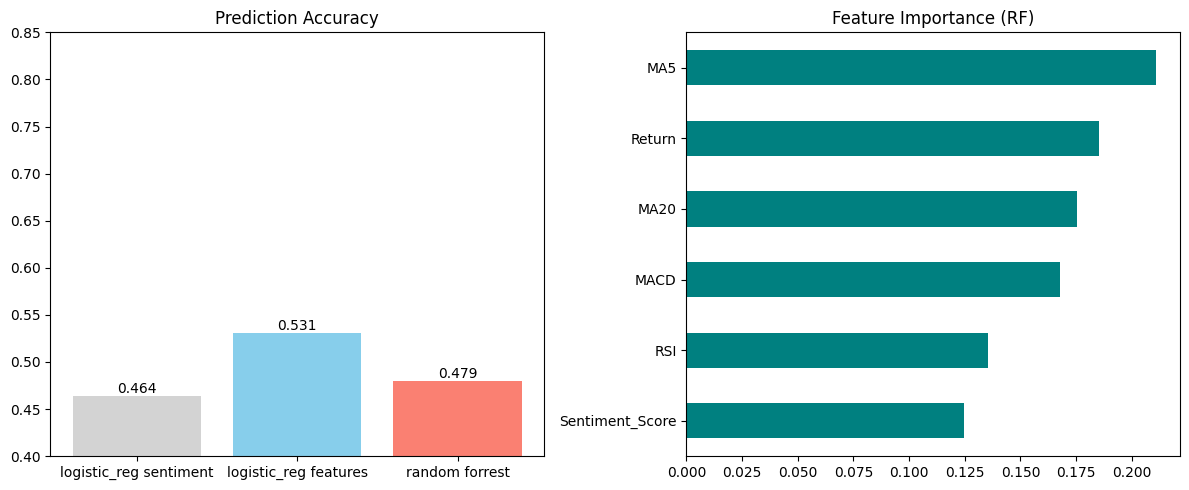

In [97]:
if __name__ == "__main__":
    run_analysis()